In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/TS/Final_TS/data')
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1giN2BXUCpTm3hi55M5Y4rqonthKMmpsM/Final_TS/data'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import datetime

In [3]:
df = pd.read_csv('coffee.csv')
df.head(3)

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.0,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.5,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.0,115.00,118.60,6165,USD


In [4]:
df.tail(3)

,Date,Open,High,Low,Close,Volume,Currency
5743,2022-08-31,240.75,240.75,239.65,239.10,12,USD
5744,2022-09-01,238.55,238.55,236.60,236.35,6,USD
5745,2022-09-02,232.50,234.05,228.28,228.42,0,USD


In [5]:
len(df.Date.unique())

5746

In [6]:
df.Currency.value_counts()

USD    5746
Name: Currency, dtype: int64

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.drop(columns='Currency',inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5746 entries, 2000-01-03 to 2022-09-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5746 non-null   float64
 1   High    5746 non-null   float64
 2   Low     5746 non-null   float64
 3   Close   5746 non-null   float64
 4   Volume  5746 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 269.3 KB


In [9]:
df.describe()

,Open,High,Low,Close,Volume
count,5746.000000,5746.000000,5746.000000,5746.000000,5746.000000
mean,127.267635,128.847034,125.784669,127.215567,8807.178907
std,50.569425,51.164948,49.851487,50.506519,9612.789034
min,41.500000,42.000000,41.500000,41.500000,0.000000
25%,98.800000,100.112500,97.862500,98.650000,61.000000
50%,120.400000,121.600000,118.950000,120.250000,7008.000000
75%,144.800000,146.000000,143.000000,144.337500,14497.750000
max,305.300000,306.250000,304.000000,304.900000,62045.000000


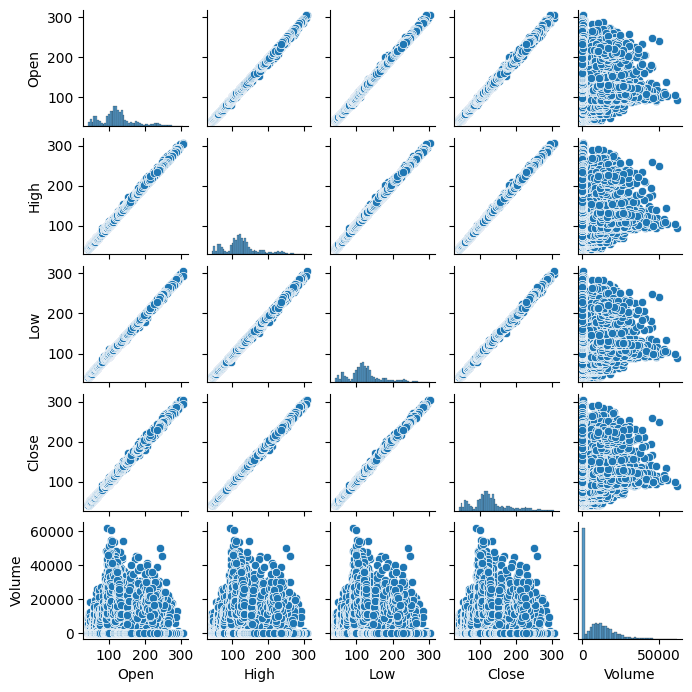

In [10]:
sns.pairplot(df,height=1.4)

In [11]:
df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.999366,0.999368,0.998644,0.111907
High,0.999366,1.000000,0.999129,0.999346,0.120768
Low,0.999368,0.999129,1.000000,0.999361,0.104490
Close,0.998644,0.999346,0.999361,1.000000,0.113157
Volume,0.111907,0.120768,0.104490,0.113157,1.000000


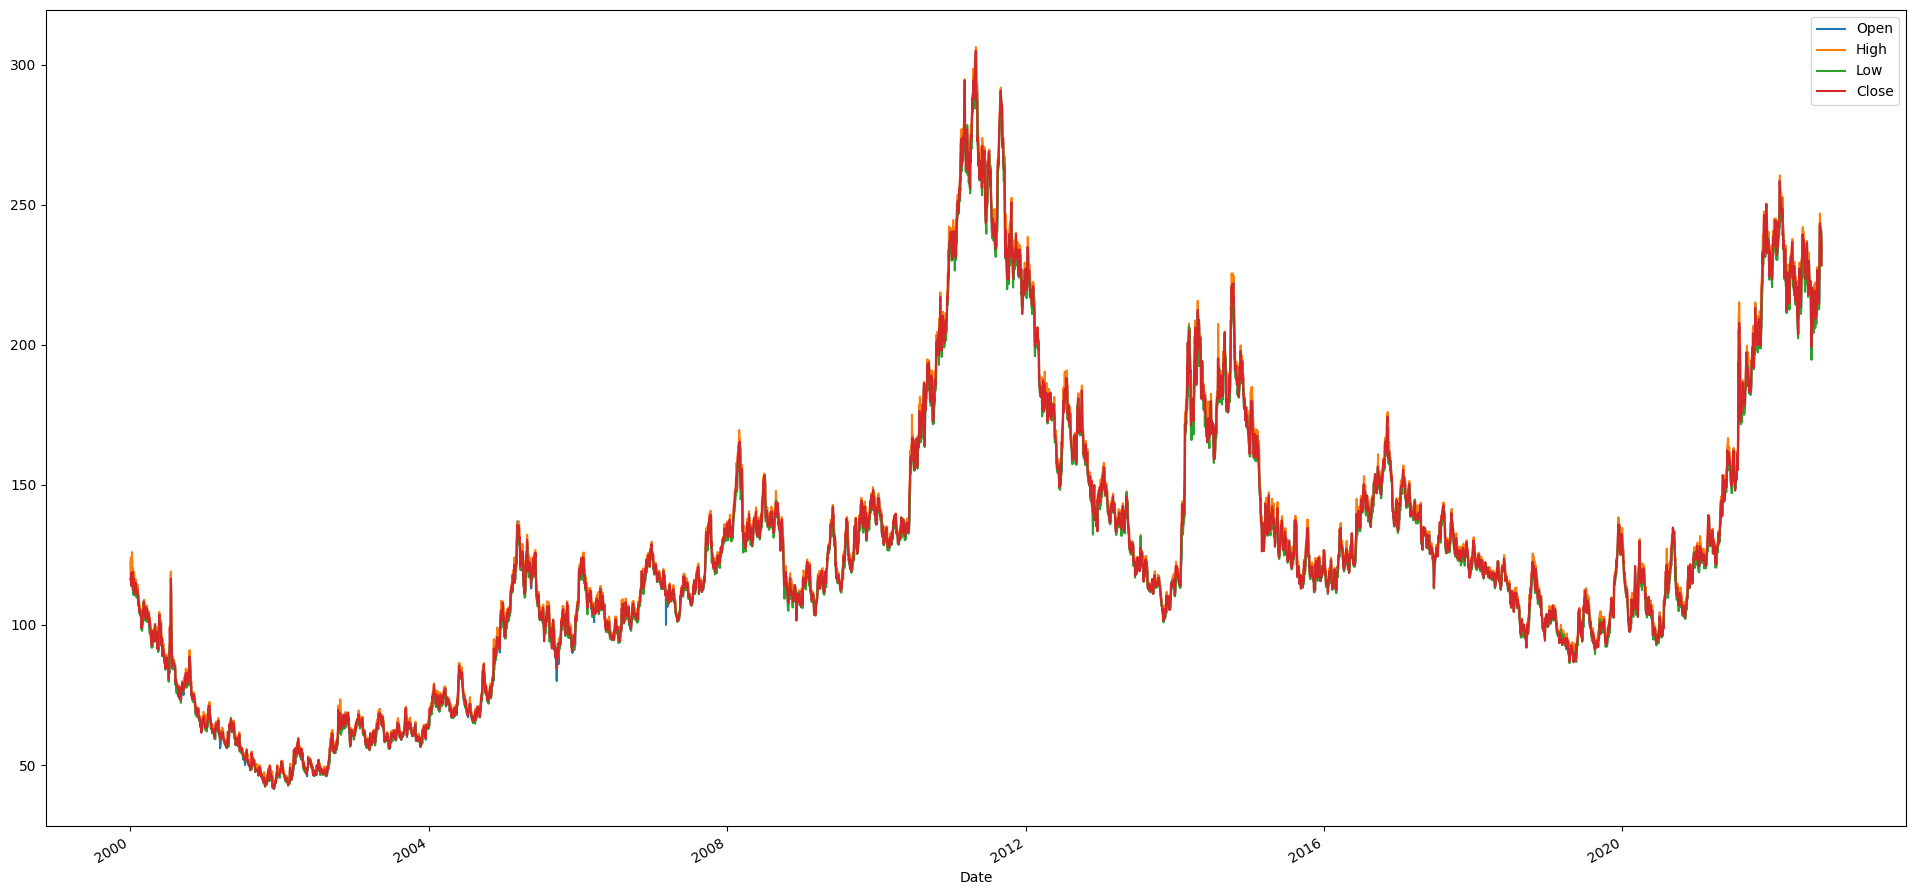

In [5]:
df[['Open','High','Low','Close']].plot(figsize=(24,12))
plt.legend()

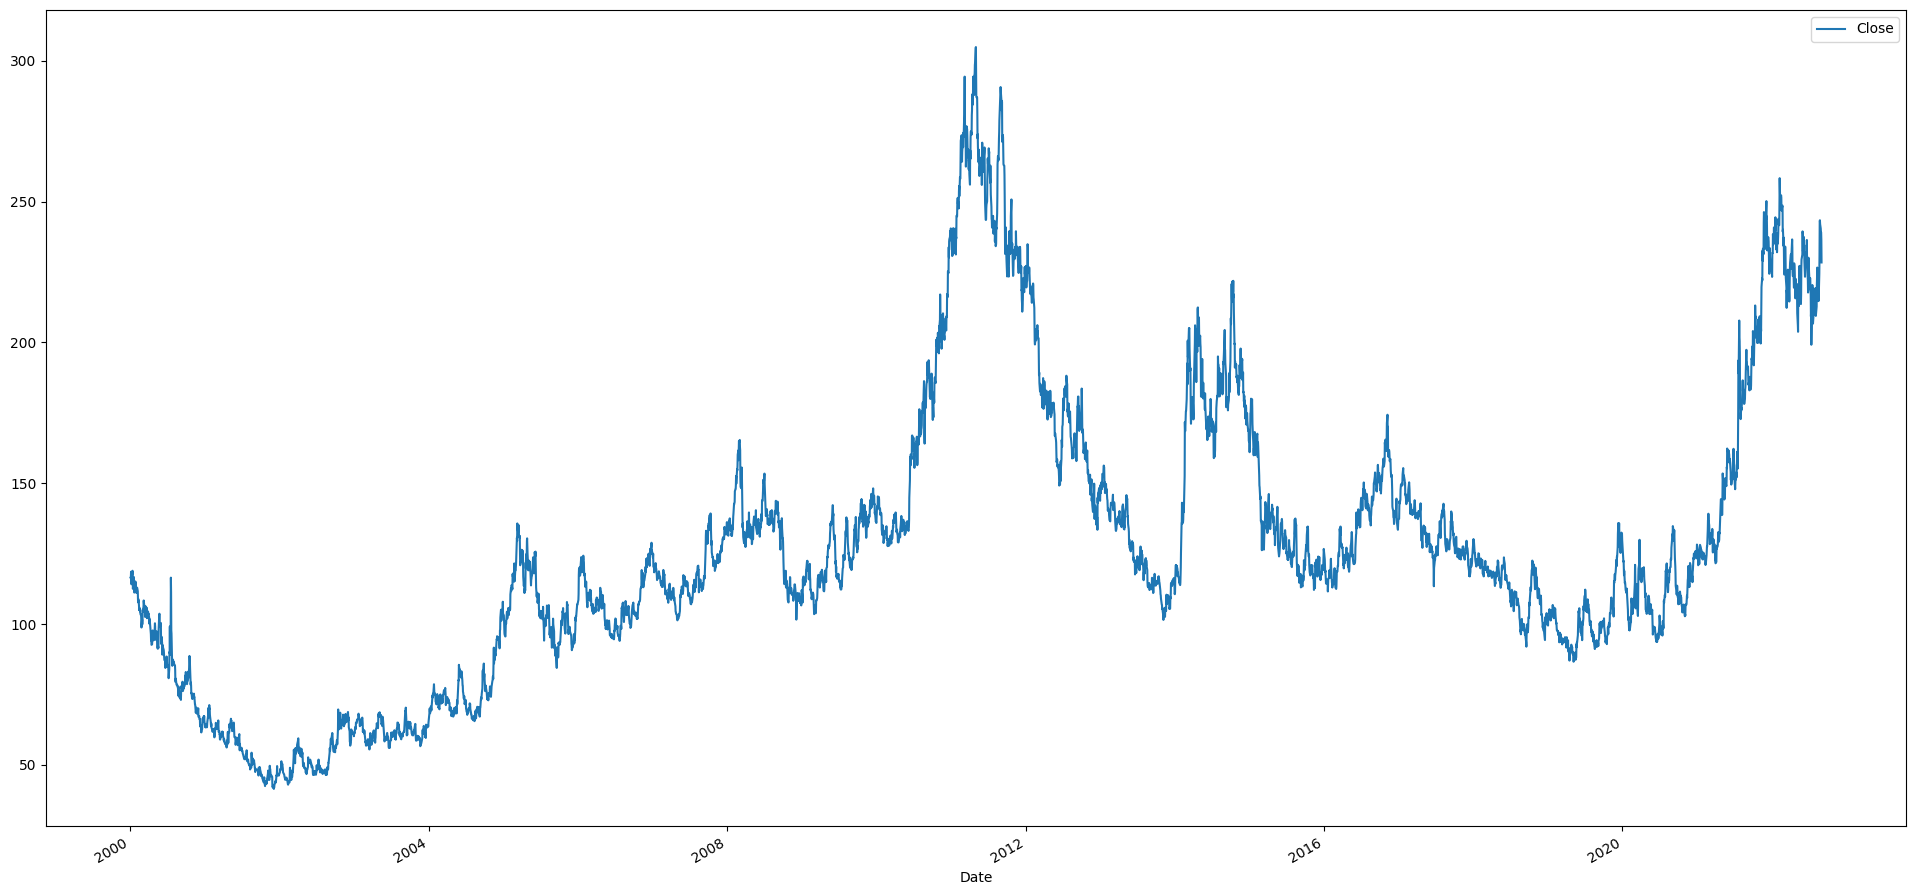

In [6]:
df['Close'].plot(figsize=(24,12))
plt.legend()

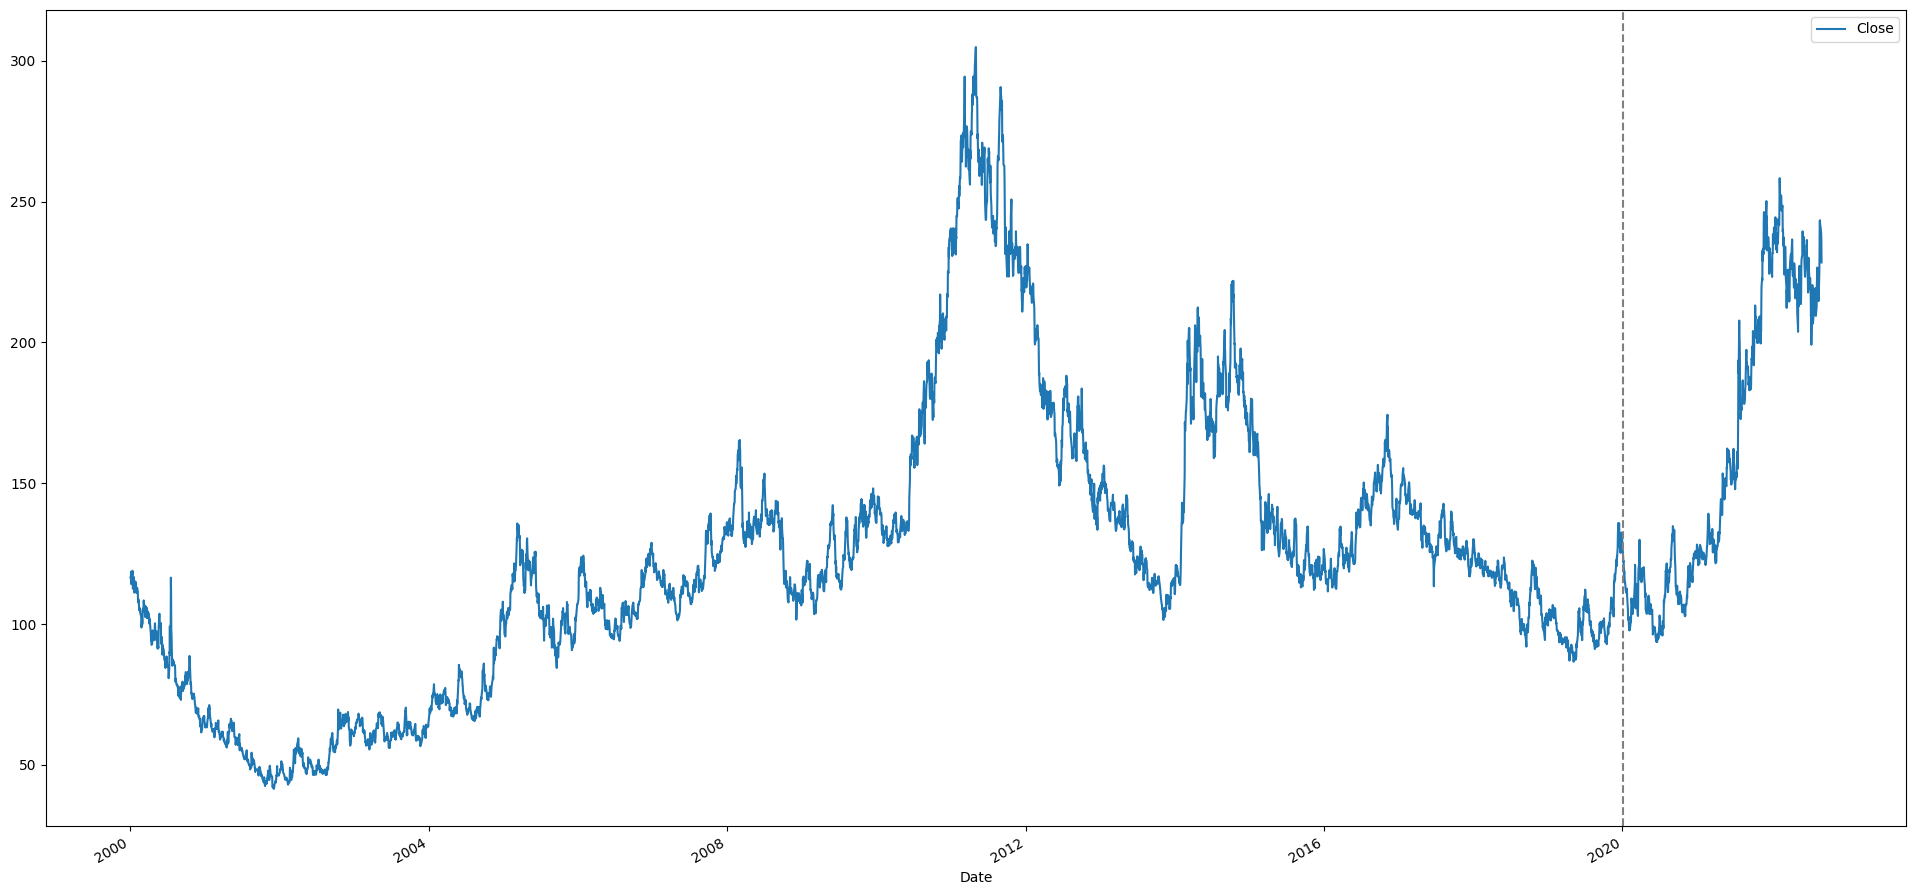

In [9]:
df['Close'].plot(figsize=(24,12))
plt.axvline(x = datetime.datetime(2020,1,2), color = 'grey', linestyle = '--')
plt.legend()

<Axes: xlabel='Date'>

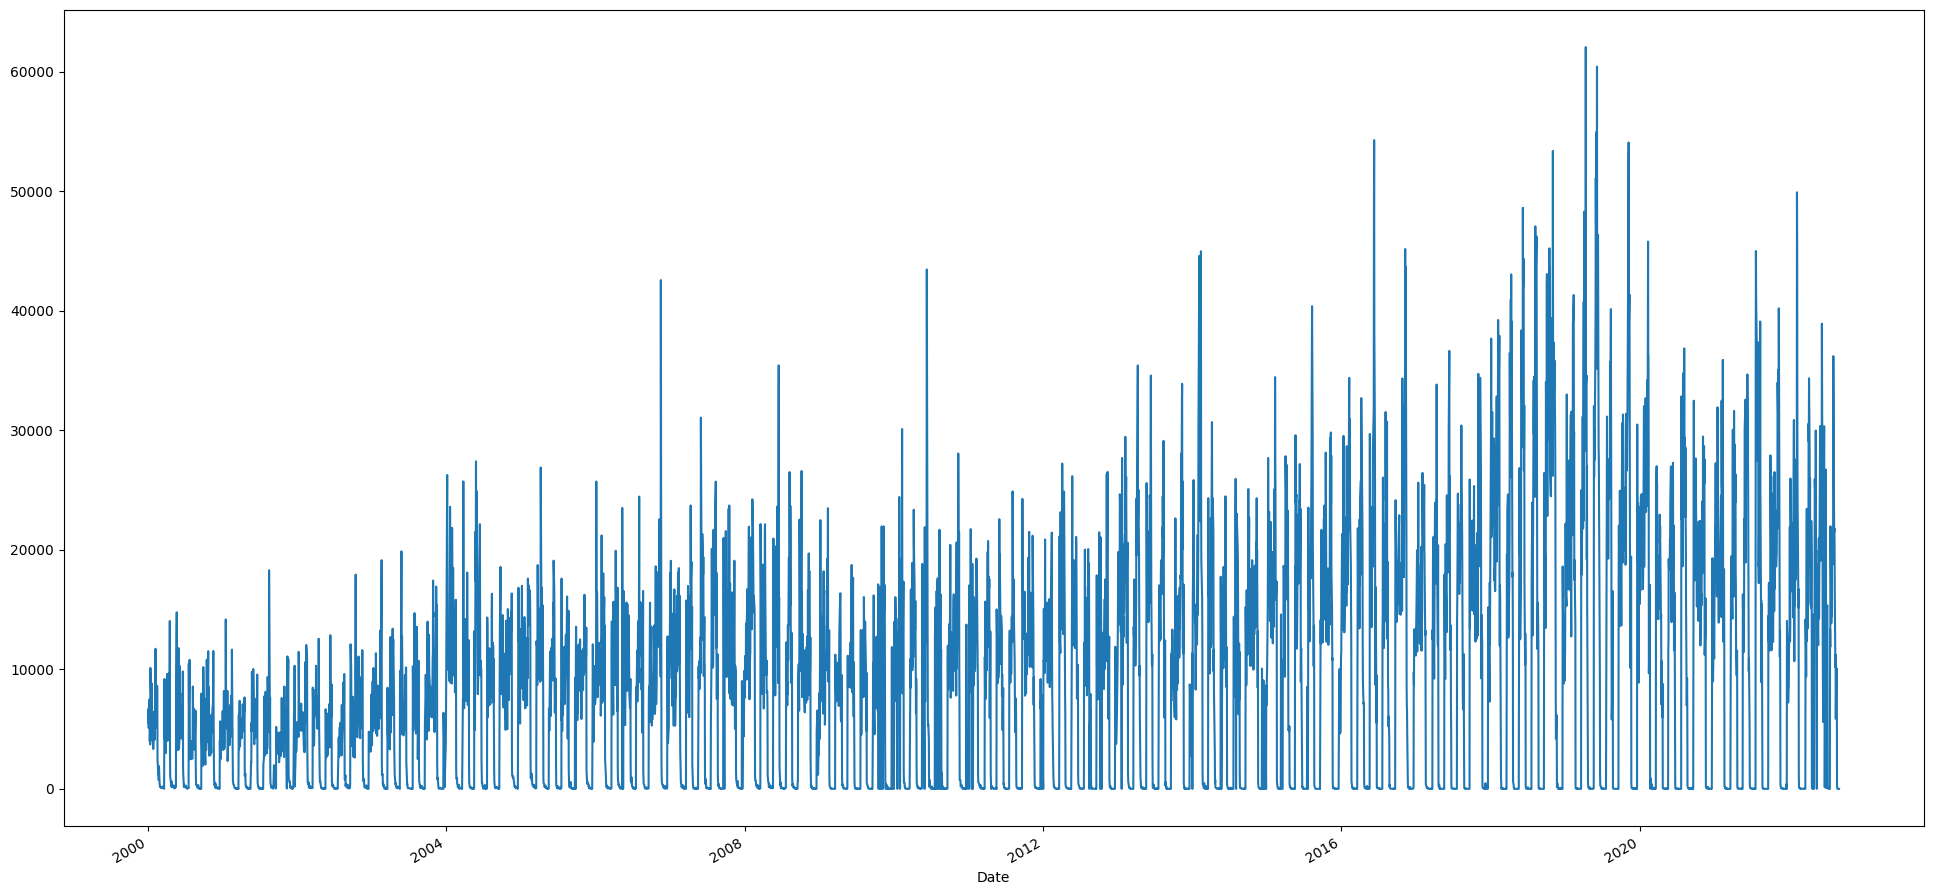

In [ ]:
df['Volume'].plot(figsize=(24,12))

<Axes: xlabel='Date'>

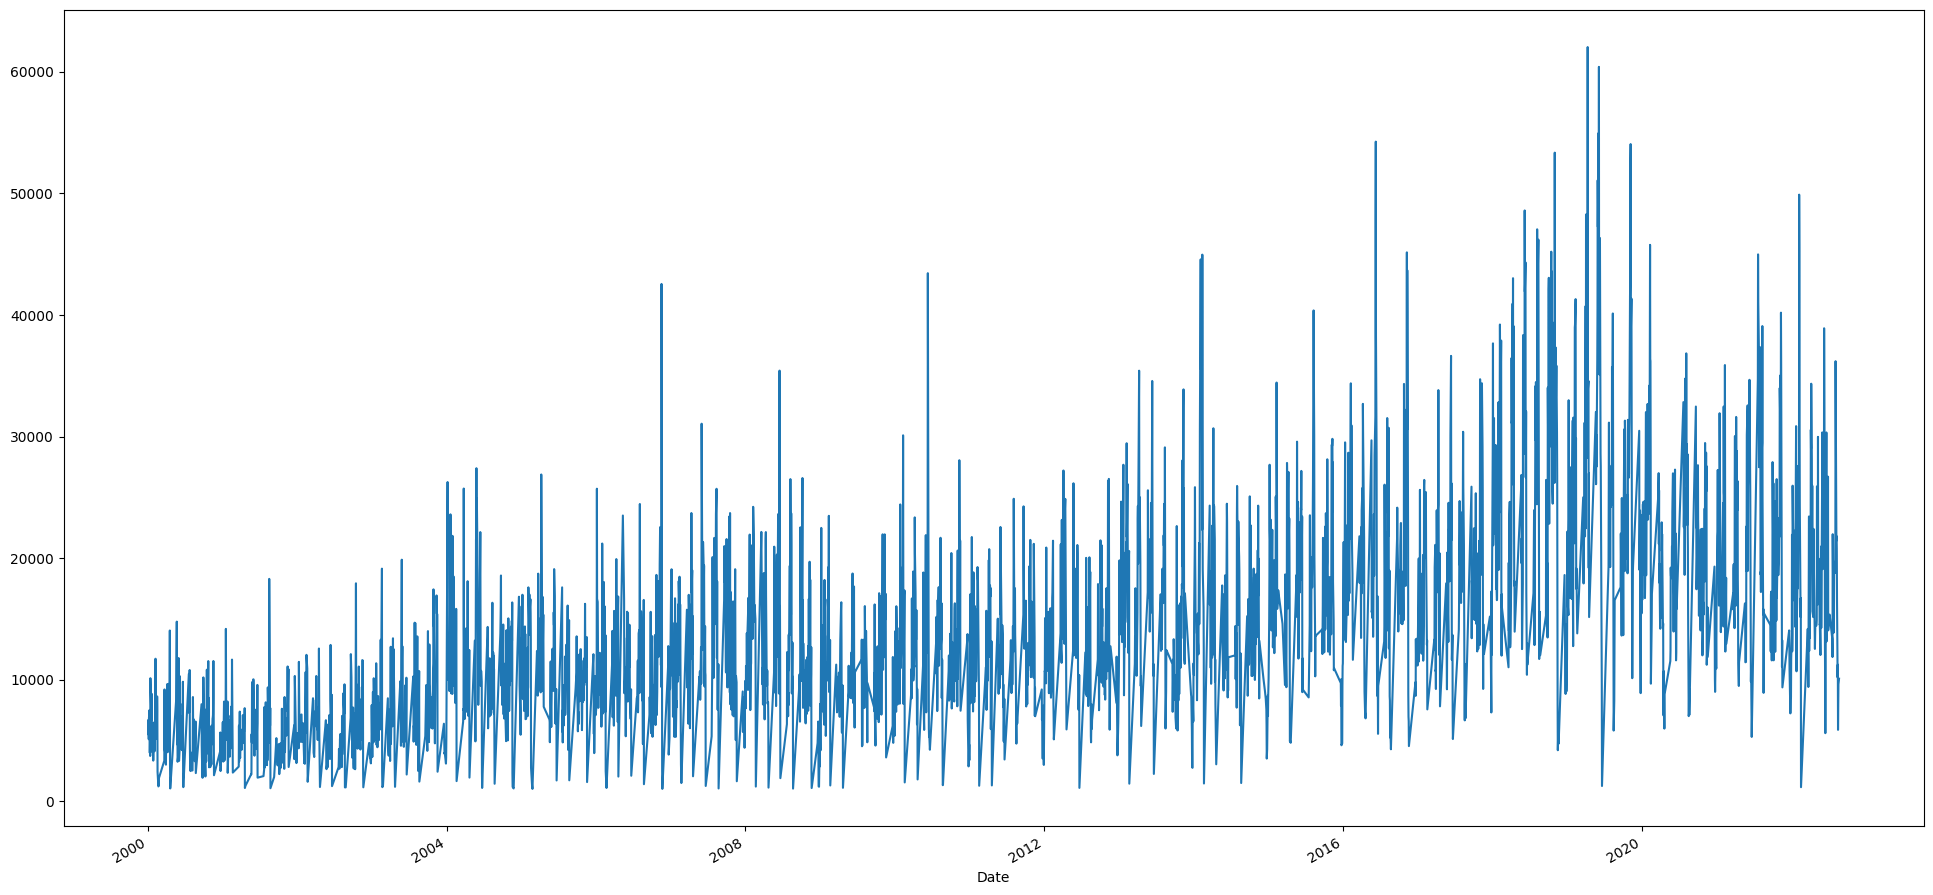

In [ ]:
df[df['Volume']>1000]['Volume'].plot(figsize=(24,12))

In [ ]:
df['holiday'] = (df['Volume']>1000).astype(int)

# Target: Close


In [10]:
df_train, df_test = df.loc[:"2020-01-01"], df.loc["2020-01-01":]
y_train = df_train['Close'].values
y_test = df_test['Close'].values

<Axes: xlabel='Date'>

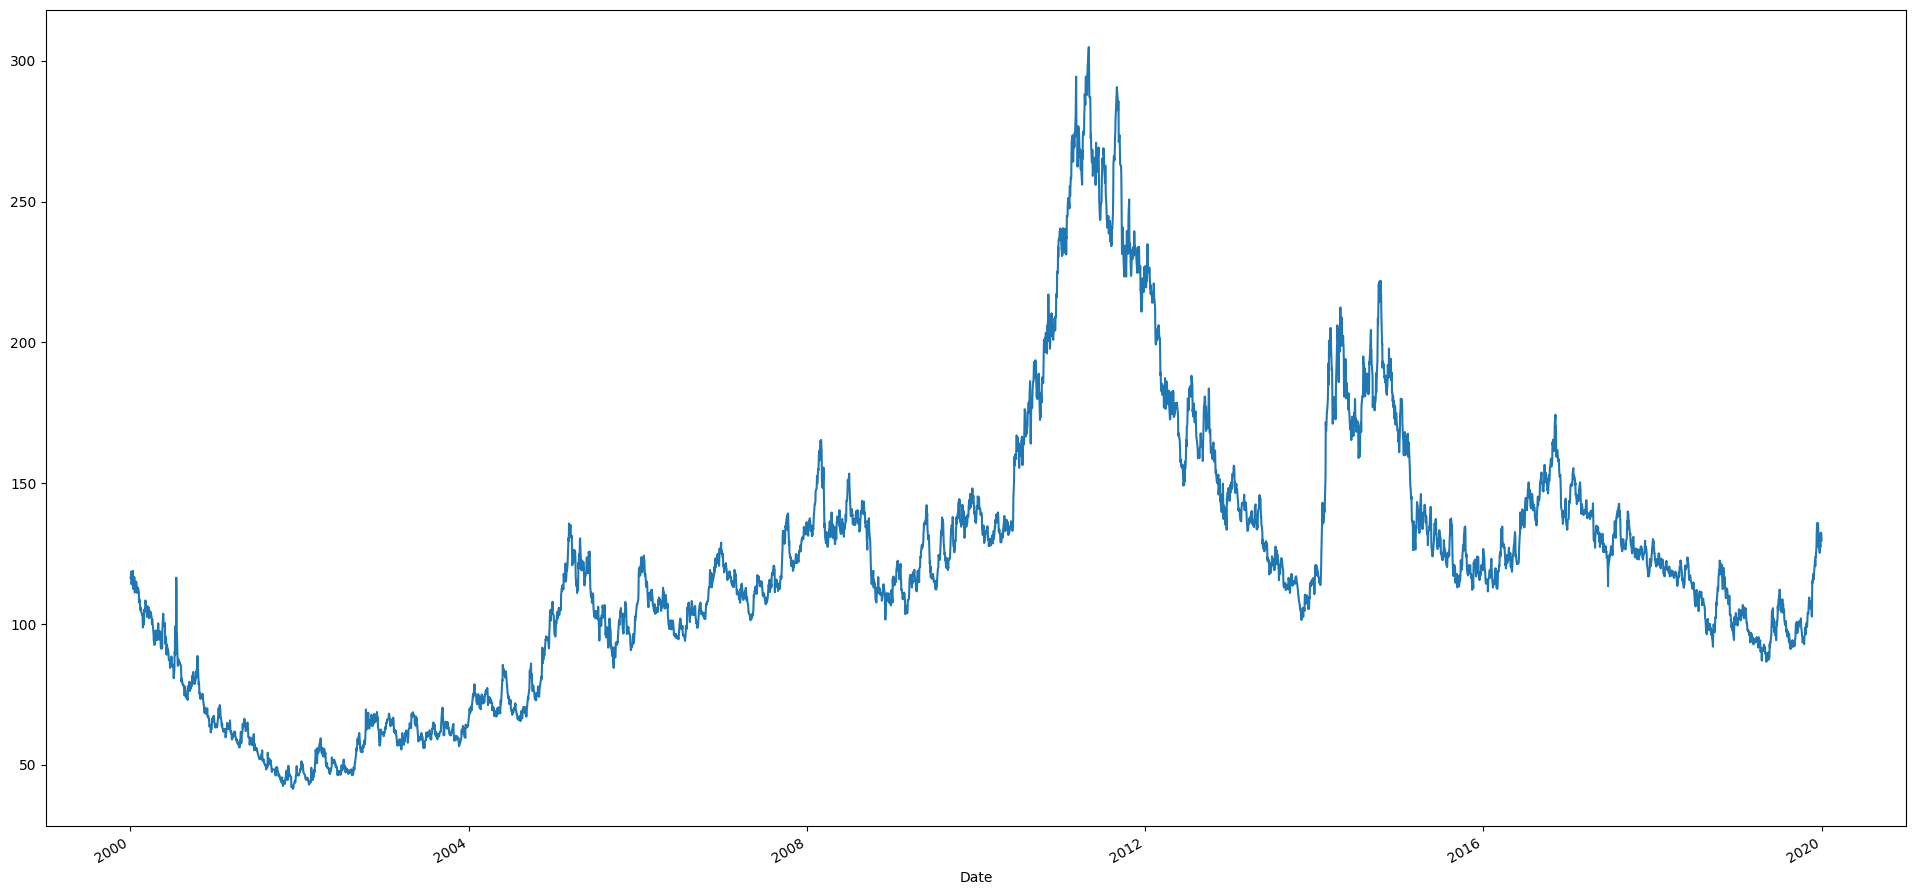

In [14]:
df_train['Close'].plot(figsize=(24,12))

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


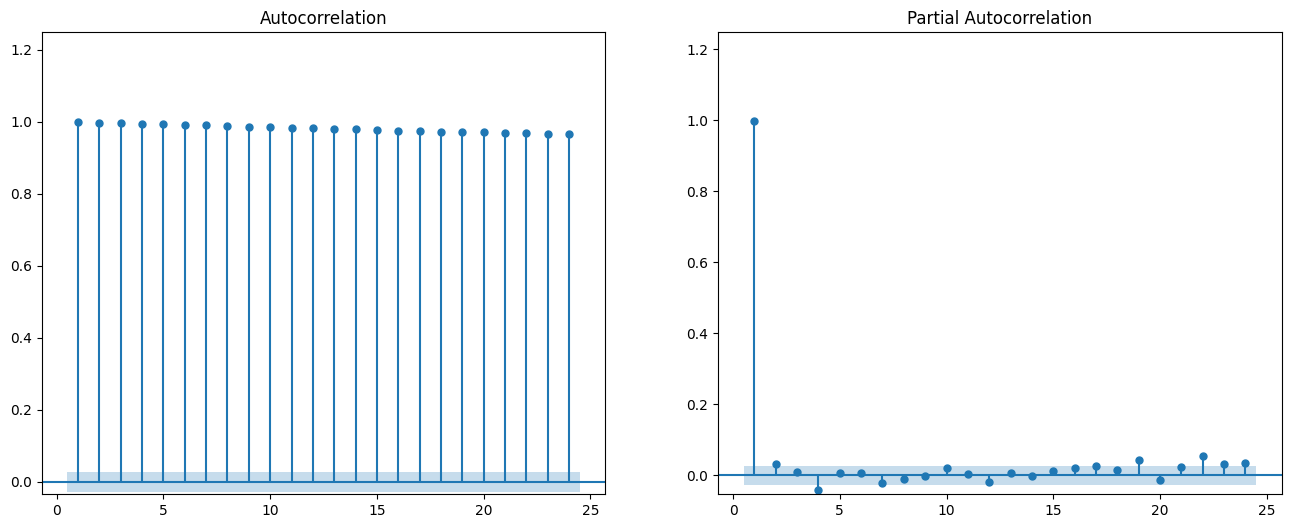

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
plot_acf(y_train, ax=ax1, lags=24, zero=False, auto_ylims=True, bartlett_confint=False)
plot_pacf(y_train, ax=ax2, lags=24, zero=False, auto_ylims=True)
plt.show()

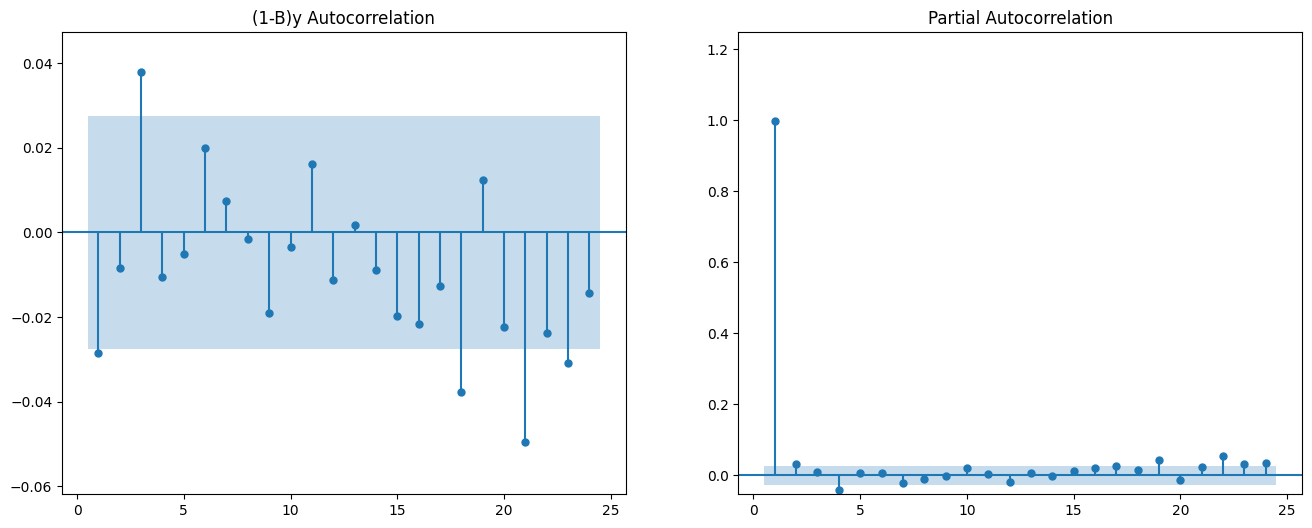

In [20]:
y1 = df_train['Close'].diff()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
plot_acf(y1, ax=ax1, lags=24, title='(1-B)y Autocorrelation', zero=False, auto_ylims=True, bartlett_confint=False, missing='drop')
plot_pacf(y_train, ax=ax2, lags=24, zero=False, auto_ylims=True)
plt.show()

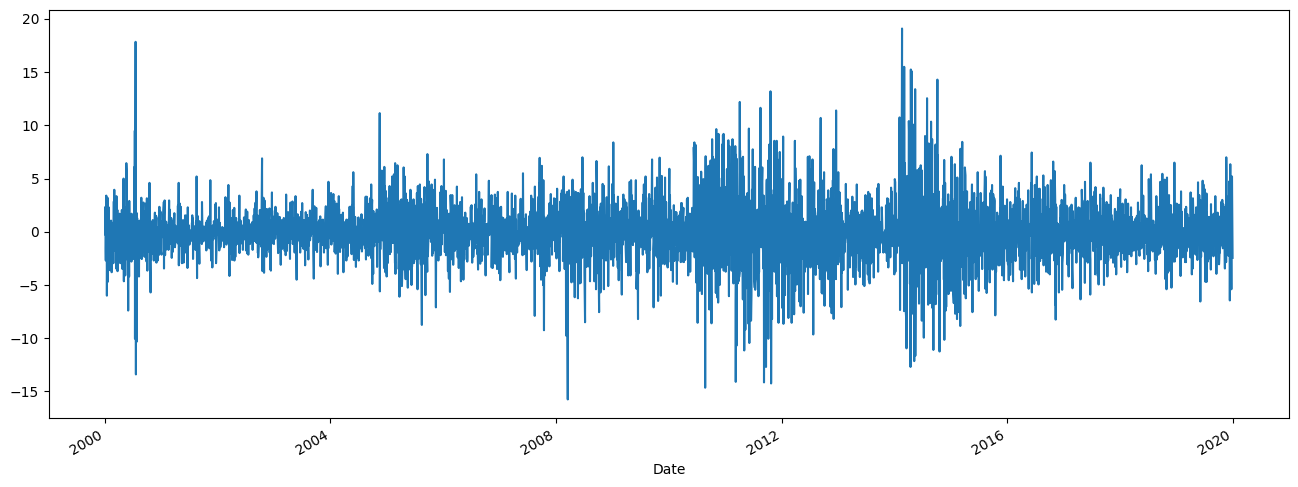

In [21]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))
y1.plot(ax=ax1)
plt.show()

## Baseline

Baseline Mean Squared Error is 15.175261127596439
Testing Mean Absolute Error is 2.8218991097922848


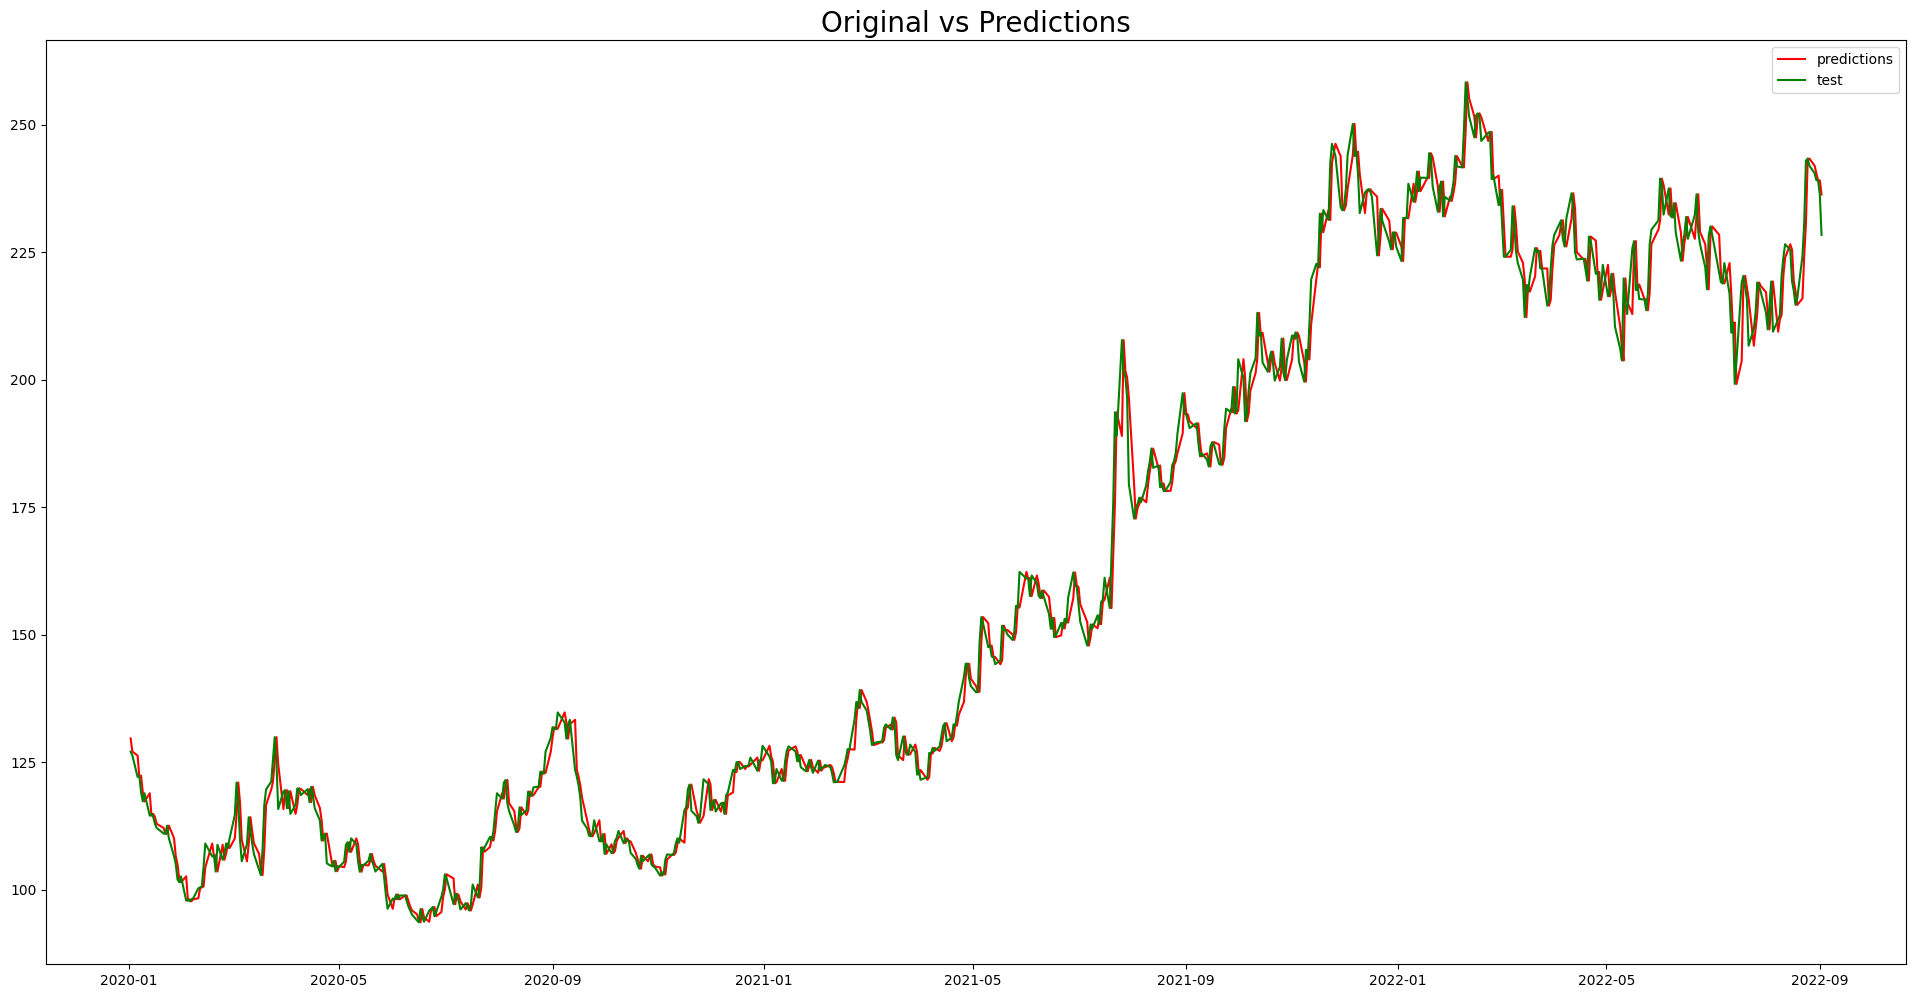

In [ ]:
pred = ([y_train[-1]]+y_test.tolist())[:-1]
df_pred = pd.DataFrame(pred)
df_pred.index = df_test.index
plt.figure(figsize=(24,12))
plt.plot(df_pred,color='red',label='predictions')
plt.plot(df_test['Close'],color='green',label='test')
plt.title('Original vs Predictions',size=20)
plt.legend(loc='best')
MSE = mean_squared_error(y_test, pred)
print('Baseline Mean Squared Error is {}'.format(MSE))
MAE = mean_absolute_error(y_test, pred)
print('Baseline Mean Absolute Error is {}'.format(MAE))

## daily

In [22]:
fit_AR1I1 = SARIMAX(y_train, order=(1,1,0), trend='c').fit()
print(fit_AR1I1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5072
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -12260.830
Date:                Mon, 12 Jun 2023   AIC                          24527.661
Time:                        12:15:34   BIC                          24547.254
Sample:                             0   HQIC                         24534.523
                               - 5072                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.038      0.071      0.943      -0.072       0.078
ar.L1         -0.0285      0.009     -3.063      0.002      -0.047      -0.010
sigma2         7.3727      0.081     90.903      0.0

<Axes: ylabel='residual'>

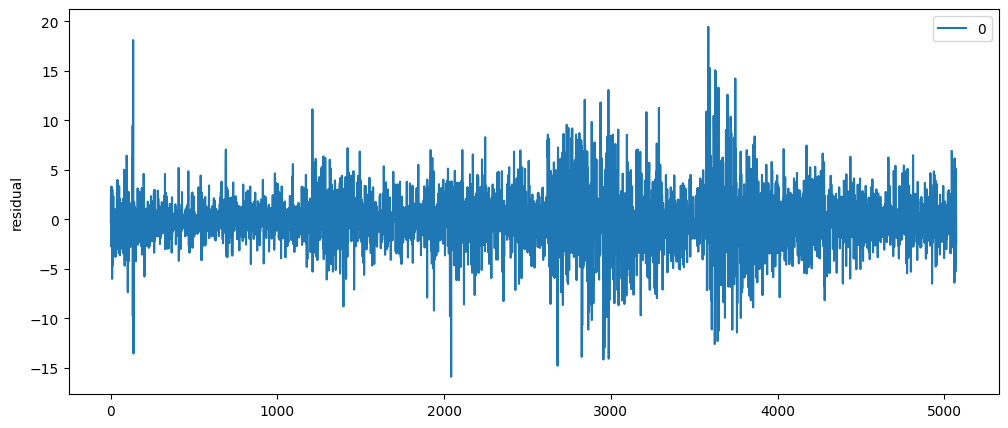

In [23]:
residuals = pd.DataFrame(fit_AR1I1.resid).iloc[1:,:]
residuals.plot(figsize=(12,5), ylabel='residual')

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


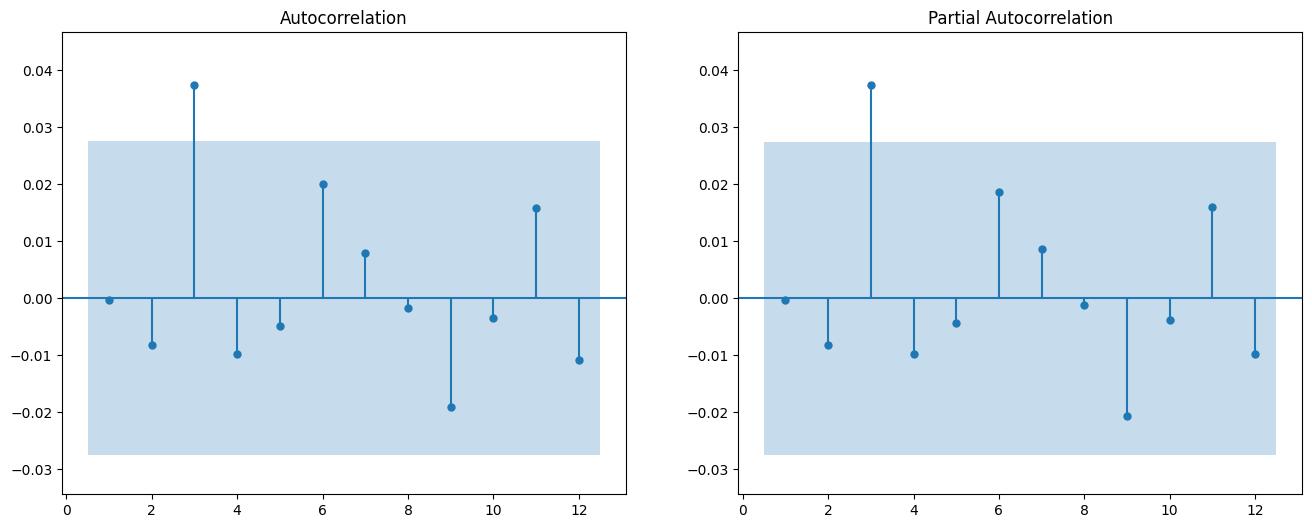

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
plot_acf(residuals.values.tolist(), ax=ax1, lags=12, zero=False, auto_ylims=True, bartlett_confint=False)
plot_pacf(residuals.values.tolist(), ax=ax2, lags=12, zero=False, auto_ylims=True)
plt.show()

In [25]:
acorr_ljungbox(residuals,lags=[6,12], model_df=1)

,lb_stat,lb_pvalue
6,10.074840,0.073142
12,14.217916,0.221169


### 三步預測

In [11]:
fit_AR1I1 = SARIMAX(y_train, order=(1,1,0), trend='c').fit()
result0 = fit_AR1I1.get_prediction(start=1,end=df_train.shape[0]-1).summary_frame(alpha = 0.05)
result0.index = df_train.index[1:]
yhat0 = result0['mean']

In [12]:
step = 3
history = [x for x in y_train[:-(step-1)]]
y_test_new = [x for x in y_train[-(step-1):]]+y_test.tolist()
predictions = []
Upper = []
Lower = []
N_test = len(y_test_new)-(step-1)
for t in range(N_test):
  fit_AR1I1 = SARIMAX(history, order=(1,1,0), trend='c').fit()
  results = fit_AR1I1.get_prediction(start=len(history),end=len(history)+(step-1)).summary_frame(alpha = 0.05)
  yhat = results['mean'][step-1]
  Upper.append(results['mean_ci_upper'][step-1])
  Lower.append(results['mean_ci_lower'][step-1])
  predictions.append(yhat)
  y = y_test_new[t]
  history.append(y)

<ipython-input-15-8a69462b651f>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allpred = yhat0.append(S_predictions)


Testing Mean Squared Error is 46.331616597220425
Testing Mean Absolute Error is 5.051730421050168


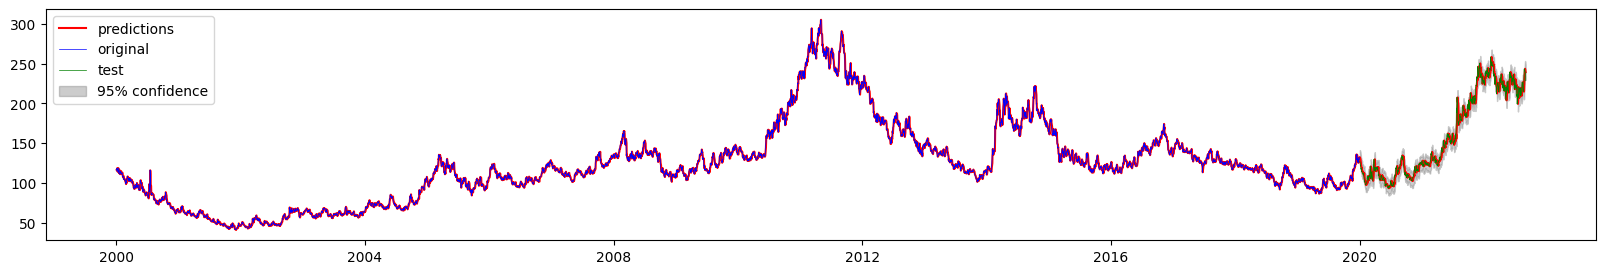

In [15]:
S_predictions = pd.Series(predictions)
allpred = yhat0.append(S_predictions)
df_predictions = pd.DataFrame(allpred)
df_predictions.index = df.index[1:]
plt.figure(figsize=(20,3))
plt.plot(df_predictions,color='red',label='predictions')
plt.plot(df_train['Close'],color='blue',label='original',linewidth=0.5)
plt.plot(df_test['Close'],color='green',label='test',linewidth=0.5)
plt.fill_between(df_test.index, np.array(Upper).reshape(len(Upper),), np.array(Lower).reshape(len(Lower),), color='gray', alpha=.4, label='95% confidence')
plt.legend()
MSE = mean_squared_error(y_test, predictions)
print('Testing Mean Squared Error is {}'.format(MSE))
MAE = mean_absolute_error(y_test, predictions)
print('Testing Mean Absolute Error is {}'.format(MAE))

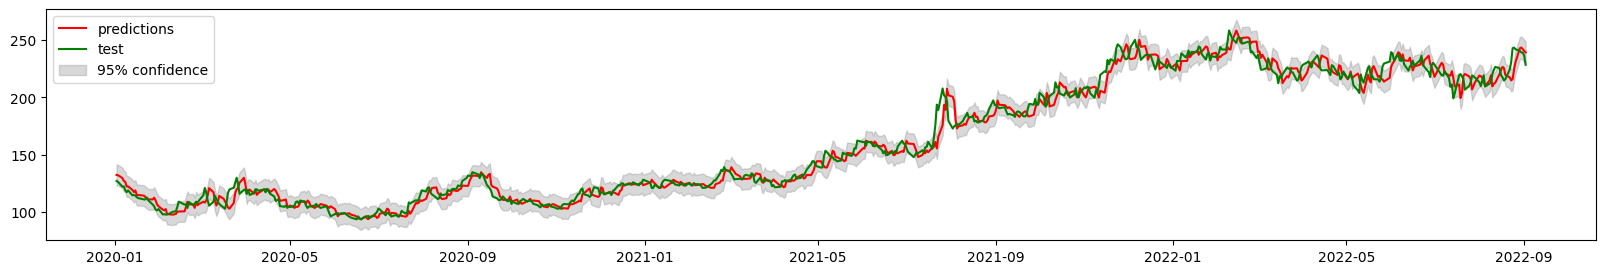

In [16]:
df_p = pd.DataFrame(predictions)
df_p.index = df_test.index
plt.figure(figsize=(20,3))
plt.plot(df_p,color='red',label='predictions')
plt.plot(df_test['Close'],color='green',label='test')
plt.fill_between(df_test.index, np.array(Upper).reshape(len(Upper),), np.array(Lower).reshape(len(Lower),), color='gray', alpha=.3, label='95% confidence')
plt.legend()

In [48]:
pred_ARIMA = df_predictions.loc["2000-01-20":]
daily_pred = pd.read_csv('/content/drive/MyDrive/TS/Final_TS/prediction/daily_3step_pred.csv')
daily_pred['ARIMA'] = pred_ARIMA.values
daily_pred.to_csv('/content/drive/MyDrive/TS/Final_TS/prediction/daily_3step_pred.csv', index=False)

## monthly

In [50]:
df_monthly = df.resample('M').mean()
df_monthly

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-31,116.035000,118.382500,113.765000,115.185000,6004.650000
2000-02-29,106.912500,108.197500,105.657500,106.477500,4686.750000
2000-03-31,104.708696,105.608696,103.700000,104.636957,1700.130435
2000-04-30,96.534211,97.810526,95.421053,96.539474,5079.000000
2000-05-31,96.813636,98.438636,95.827273,96.934091,2853.181818
...,...,...,...,...,...
2022-05-31,217.992857,221.114286,214.090476,218.082381,16666.238095
2022-06-30,230.066667,234.145238,226.811905,230.292857,19171.095238
2022-07-31,216.073000,217.967500,212.446500,215.447500,8784.000000


In [56]:
df_m_train, df_m_test = df_monthly.loc[:"2020-01-01"], df_monthly.loc["2020-01-01":]
y_m_train = df_m_train['Close'].values
y_m_test = df_m_test['Close'].values

### 一步預測

In [57]:
fit_AR1I1 = SARIMAX(y_m_train, order=(1,1,0), trend='c').fit()
result0 = fit_AR1I1.get_prediction(start=1,end=df_m_train.shape[0]-1).summary_frame(alpha = 0.05)
result0.index = df_m_train.index[1:]
yhat0 = result0['mean']

In [58]:
history = [x for x in y_m_train]
predictions = []
Upper = []
Lower = []
N_test = len(y_m_test)
for t in range(N_test):
  fit_AR1I1 = SARIMAX(history, order=(1,1,0), trend='c').fit()
  results = fit_AR1I1.get_prediction(start=len(history),end=len(history)).summary_frame(alpha = 0.05)
  results.index = df_m_test.iloc[:1].index
  yhat = results['mean']
  Upper.append(results['mean_ci_upper'][0])
  Lower.append(results['mean_ci_lower'][0])
  predictions.append(yhat)
  y = y_m_test[t]
  history.append(y)

<ipython-input-61-62b2839960d5>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allpred = yhat0.append(predictions)


Testing Mean Squared Error is 116.24373726197038
Testing Mean Absolute Error is 9.13153719067305


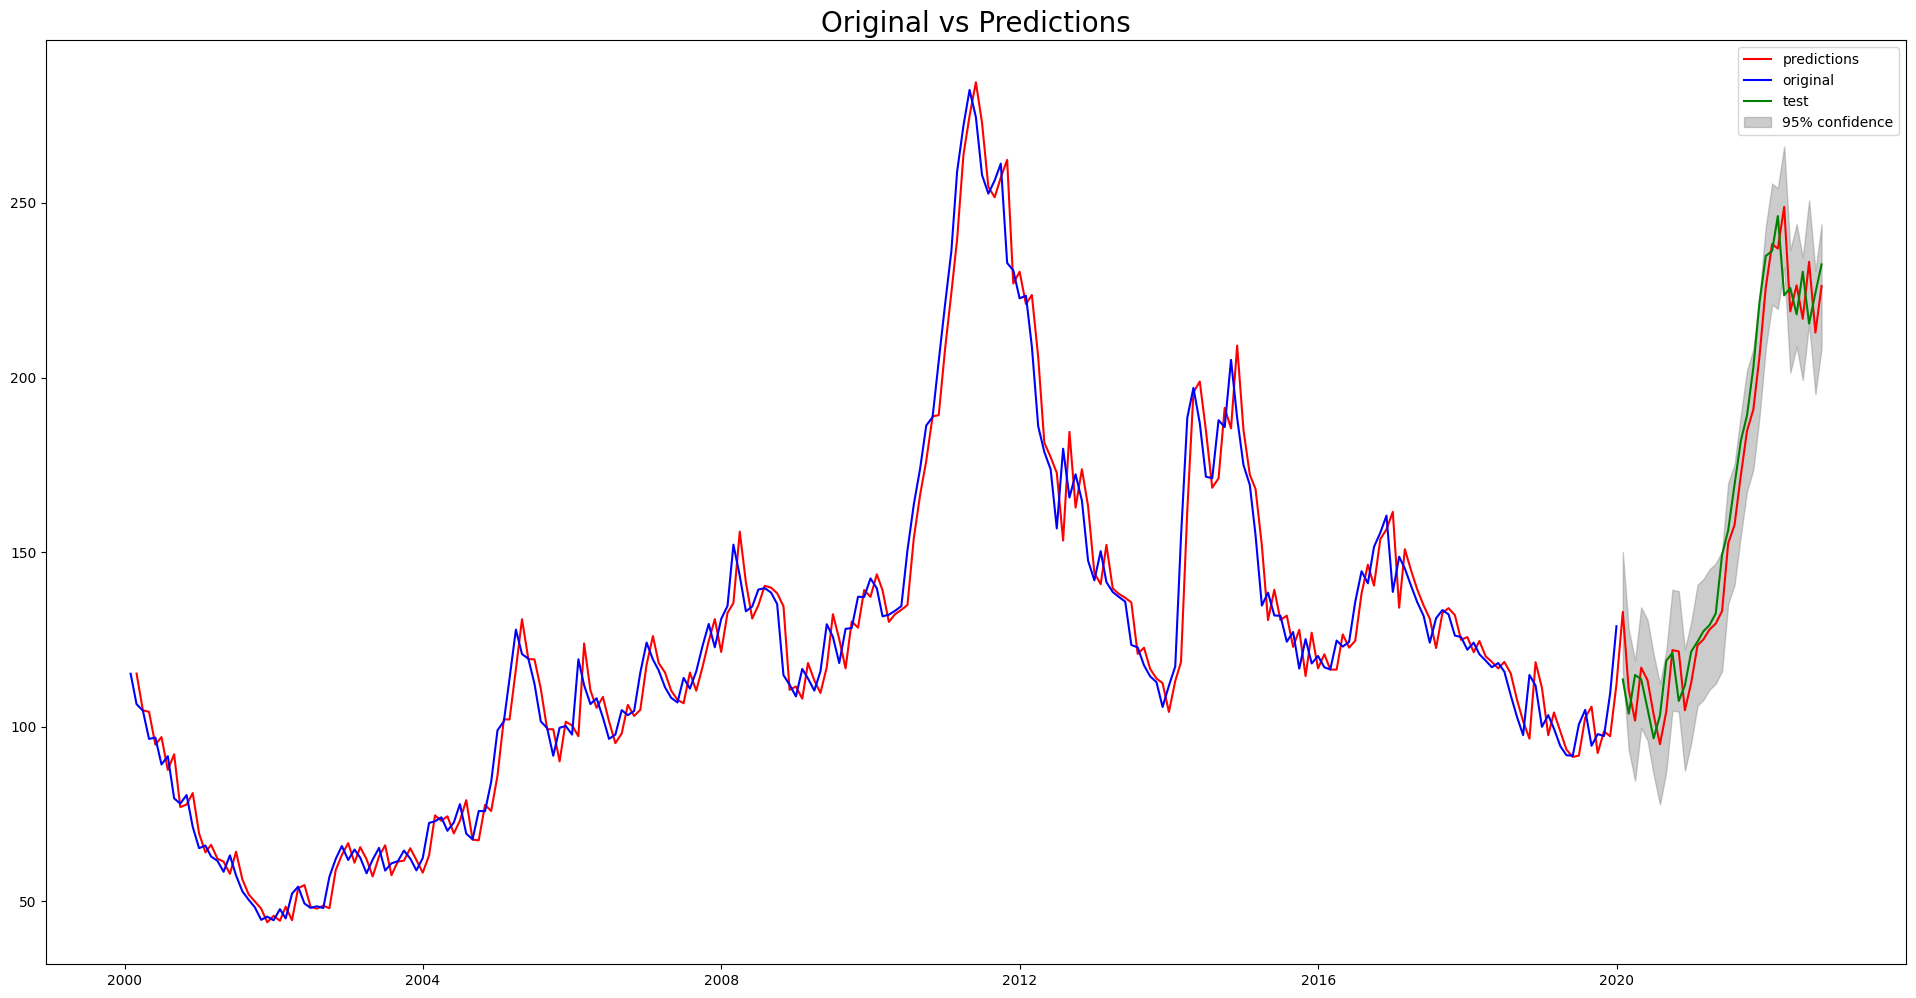

In [61]:
allpred = yhat0.append(predictions)
df_predictions = pd.DataFrame(allpred)
df_predictions.index = df_monthly.index[1:]
plt.figure(figsize=(24,12))
plt.plot(df_predictions,color='red',label='predictions')
plt.plot(df_m_train['Close'],color='blue',label='original')
plt.plot(df_m_test['Close'],color='green',label='test')
plt.fill_between(df_m_test.index, np.array(Upper).reshape(len(Upper),), np.array(Lower).reshape(len(Lower),), color='gray', alpha=.4, label='95% confidence')
plt.title('Original vs Predictions',size=20)
plt.legend(loc='best')
MSE = mean_squared_error(y_m_test, predictions)
print('Testing Mean Squared Error is {}'.format(MSE))
MAE = mean_absolute_error(y_m_test, predictions)
print('Testing Mean Absolute Error is {}'.format(MAE))

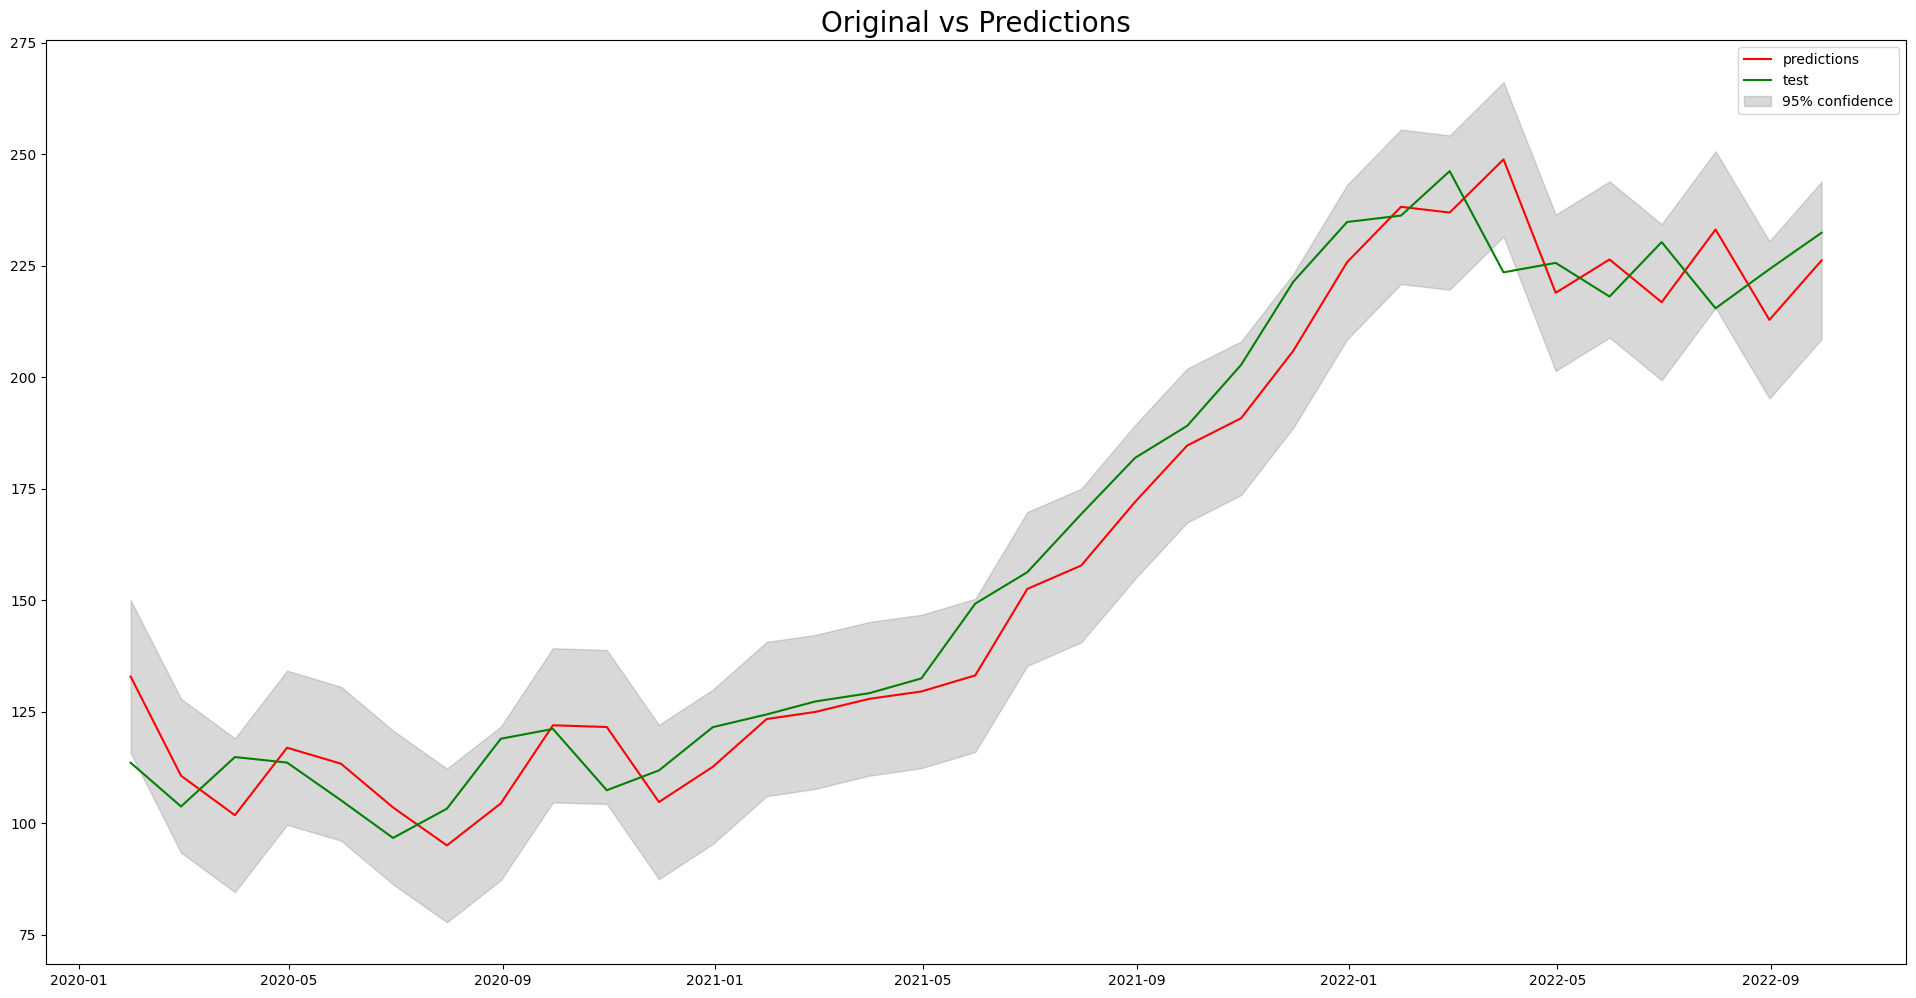

In [62]:
df_p = pd.DataFrame(predictions)
df_p.index = df_m_test.index
plt.figure(figsize=(24,12))
plt.plot(df_p,color='red',label='predictions')
plt.plot(df_m_test['Close'],color='green',label='test')
plt.fill_between(df_m_test.index, np.array(Upper).reshape(len(Upper),), np.array(Lower).reshape(len(Lower),), color='gray', alpha=.3, label='95% confidence')
plt.title('Original vs Predictions',size=20)
plt.legend(loc='best')

In [64]:
pred_m1_ARIMA = df_predictions.loc["2000-04-20":]
m1_pred = pd.read_csv('/content/drive/MyDrive/TS/Final_TS/prediction/monthly_1step_pred.csv')
m1_pred['ARIMA'] = pred_m1_ARIMA.values
m1_pred.to_csv('/content/drive/MyDrive/TS/Final_TS/prediction/monthly_1step_pred.csv', index=False)

### 三步預測

In [65]:
fit_AR1I1 = SARIMAX(y_m_train, order=(1,1,0), trend='c').fit()
result0 = fit_AR1I1.get_prediction(start=1,end=df_m_train.shape[0]-1).summary_frame(alpha = 0.05)
result0.index = df_m_train.index[1:]
yhat0 = result0['mean']

In [66]:
step = 3
history = [x for x in y_m_train[:-(step-1)]]
y_test_new = [x for x in y_m_train[-(step-1):]]+y_m_test.tolist()
predictions = []
Upper = []
Lower = []
N_test = len(y_test_new)-(step-1)
for t in range(N_test):
  fit_AR1I1 = SARIMAX(history, order=(1,1,0), trend='c').fit()
  results = fit_AR1I1.get_prediction(start=len(history),end=len(history)+(step-1)).summary_frame(alpha = 0.05)
  yhat = results['mean'][step-1]
  Upper.append(results['mean_ci_upper'][step-1])
  Lower.append(results['mean_ci_lower'][step-1])
  predictions.append(yhat)
  y = y_test_new[t]
  history.append(y)

<ipython-input-68-3138bcf0f189>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allpred = yhat0.append(S_predictions)


Testing Mean Squared Error is 431.7422853752759
Testing Mean Absolute Error is 17.55035402868931


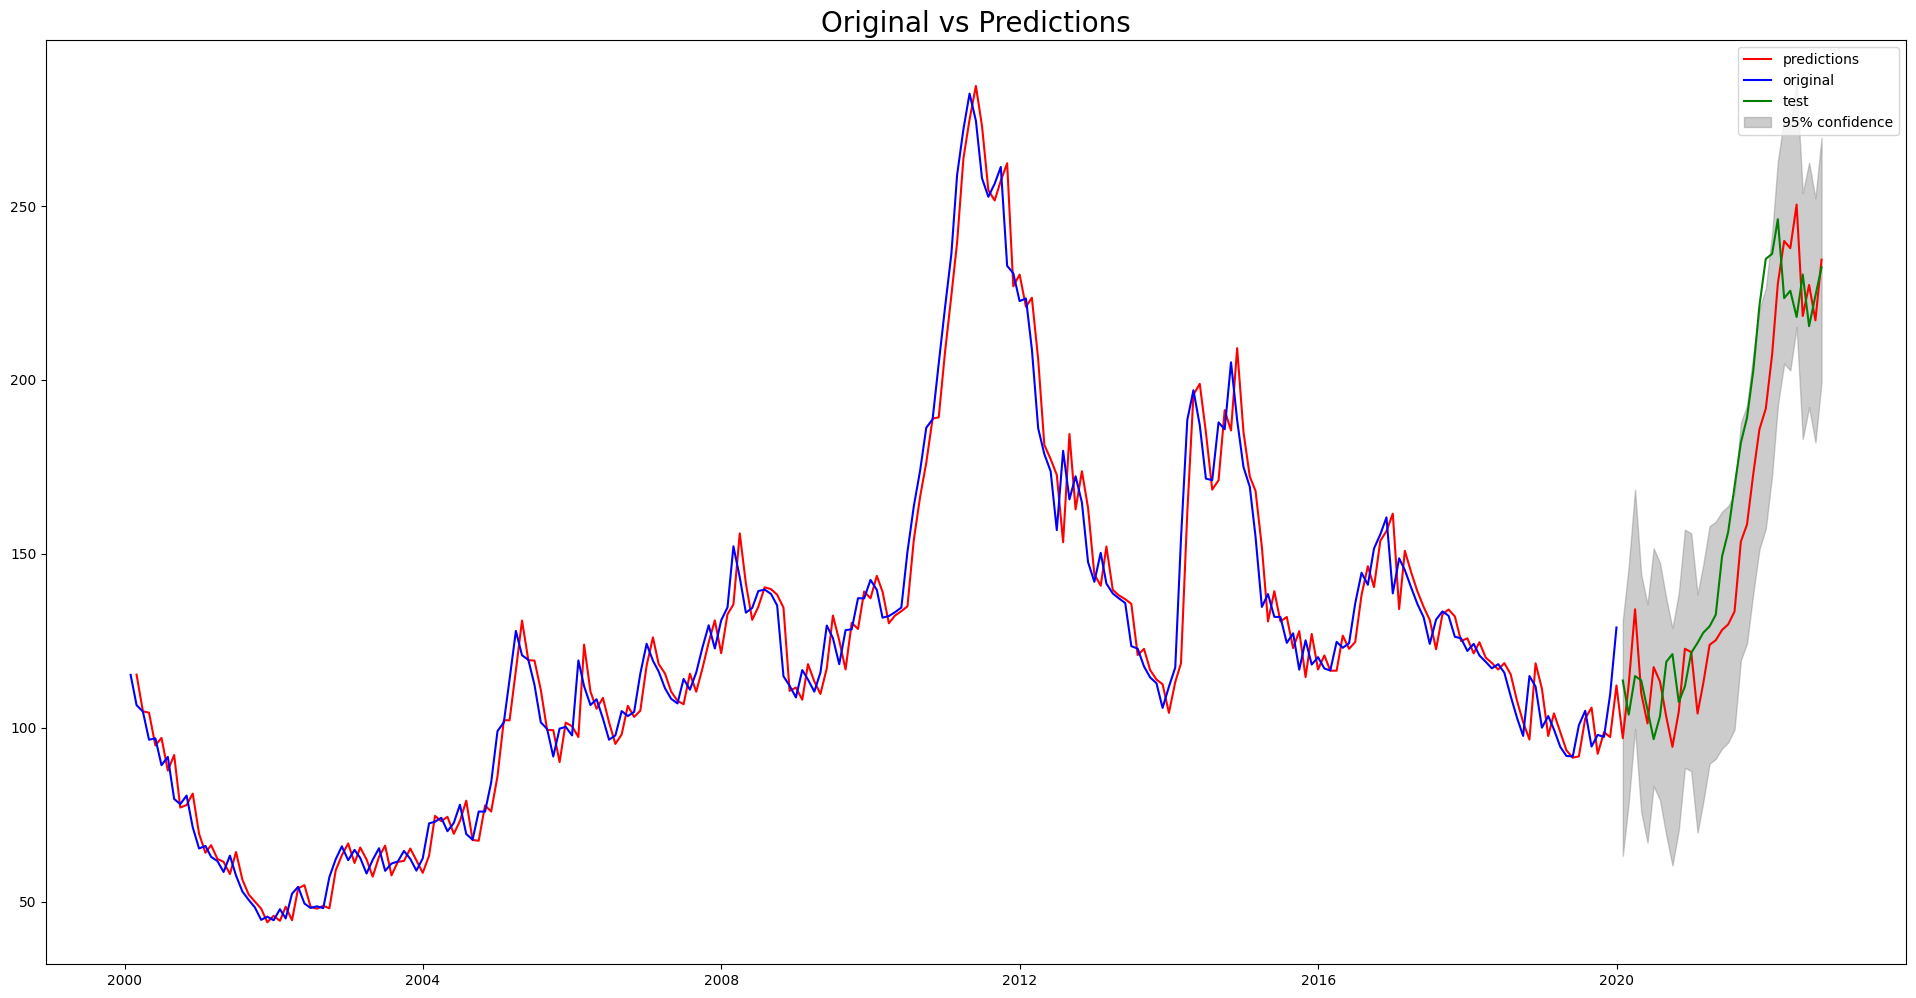

In [68]:
S_predictions = pd.Series(predictions)
allpred = yhat0.append(S_predictions)
df_predictions = pd.DataFrame(allpred)
df_predictions.index = df_monthly.index[1:]
plt.figure(figsize=(24,12))
plt.plot(df_predictions,color='red',label='predictions')
plt.plot(df_m_train['Close'],color='blue',label='original')
plt.plot(df_m_test['Close'],color='green',label='test')
plt.fill_between(df_m_test.index, np.array(Upper).reshape(len(Upper),), np.array(Lower).reshape(len(Lower),), color='gray', alpha=.4, label='95% confidence')
plt.title('Original vs Predictions',size=20)
plt.legend(loc='best')
MSE = mean_squared_error(y_m_test, predictions)
print('Testing Mean Squared Error is {}'.format(MSE))
MAE = mean_absolute_error(y_m_test, predictions)
print('Testing Mean Absolute Error is {}'.format(MAE))

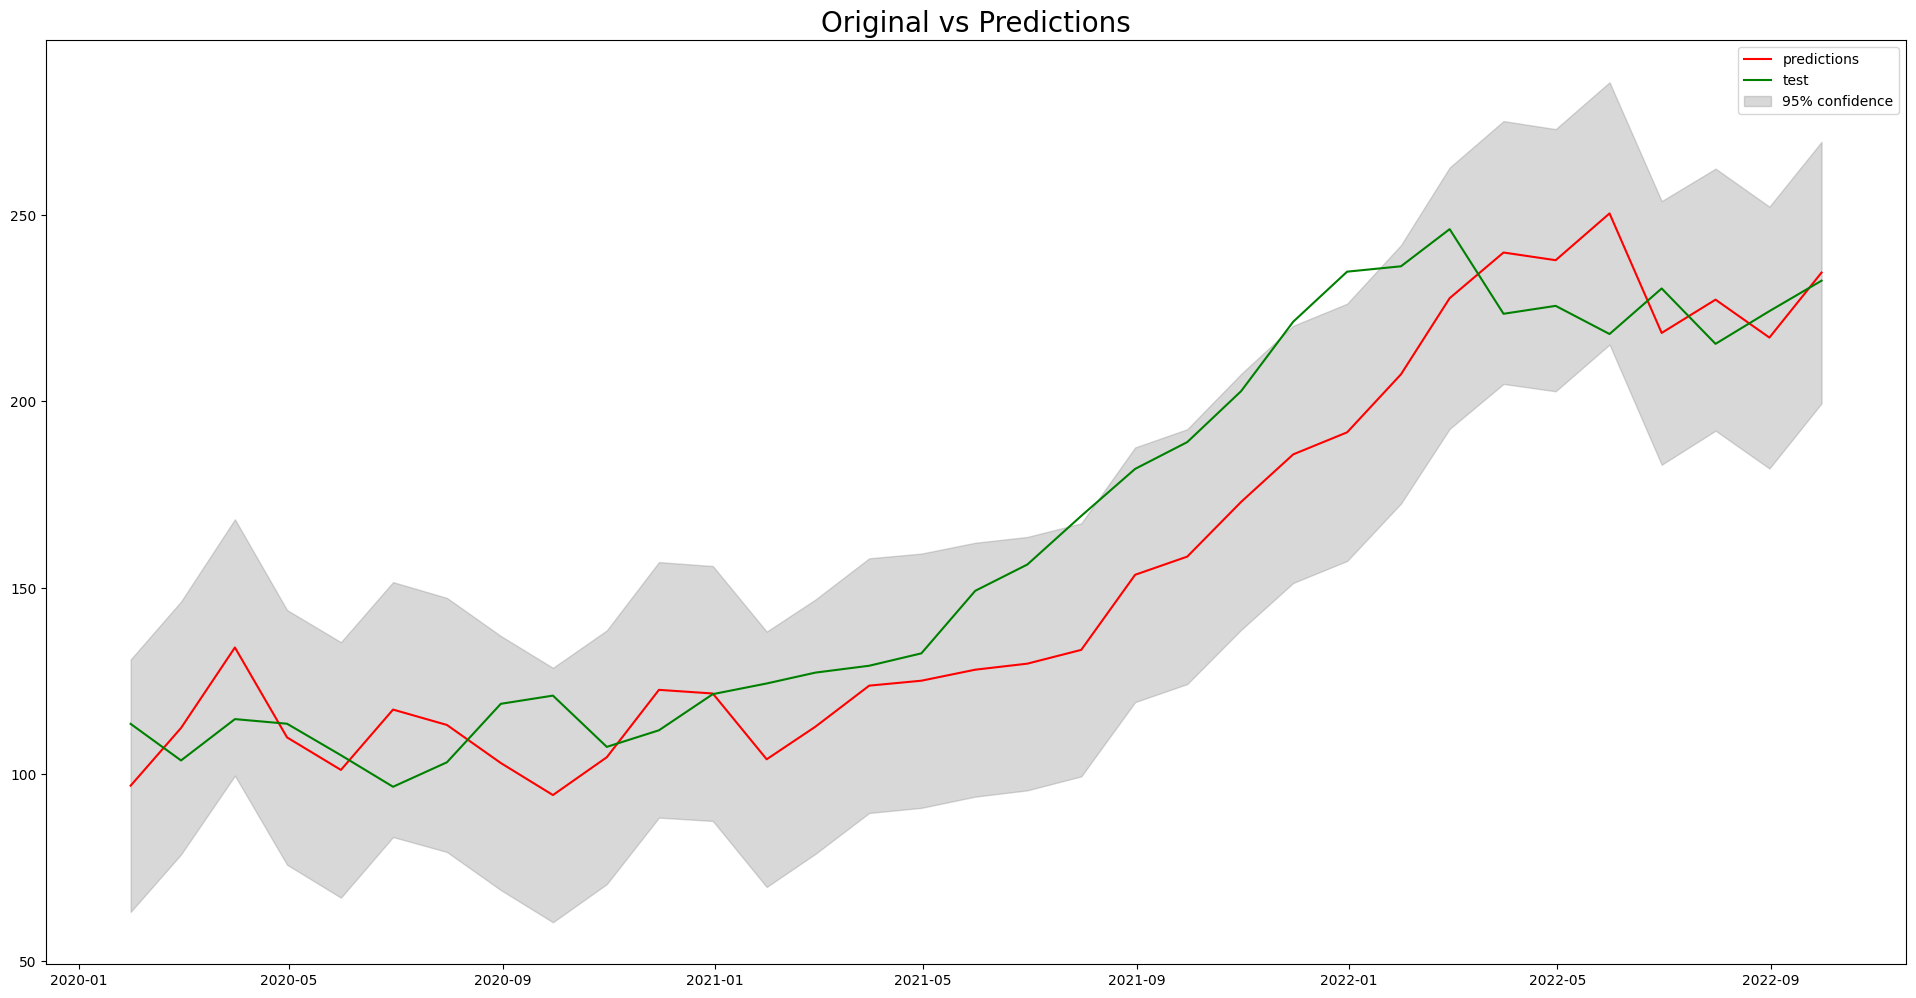

In [69]:
df_p = pd.DataFrame(predictions)
df_p.index = df_m_test.index
plt.figure(figsize=(24,12))
plt.plot(df_p,color='red',label='predictions')
plt.plot(df_m_test['Close'],color='green',label='test')
plt.fill_between(df_m_test.index, np.array(Upper).reshape(len(Upper),), np.array(Lower).reshape(len(Lower),), color='gray', alpha=.3, label='95% confidence')
plt.title('Original vs Predictions',size=20)
plt.legend(loc='best')

In [70]:
pred_m3_ARIMA = df_predictions.loc["2000-06-20":]
m3_pred = pd.read_csv('/content/drive/MyDrive/TS/Final_TS/prediction/monthly_3step_pred.csv')
m3_pred['ARIMA'] = pred_m3_ARIMA.values
m3_pred.to_csv('/content/drive/MyDrive/TS/Final_TS/prediction/monthly_3step_pred.csv', index=False)